# **Exercise sheet 5**
*Group 1: Chiara Lesa, Galvin Alexander Hoang,  Anna Novikova*

### **Exercise 1 (Constant volvol SABR-model)**
Write a Deep-hedging algorithm (for a European call with strike $K=100$ and maturity $T=2$) using the $P$-dynamics (and an other one with the $Q$-dynamics) of the following model:
 $$ dS_t = \mu S_t dt + \sigma(S_t) dW_t,\quad S_0 = 100, $$
 where $\sigma(x) = 0.2 |x|^{0.7}$ and $\mu =0.06$.</p>

How well does it work under $P$? </li>

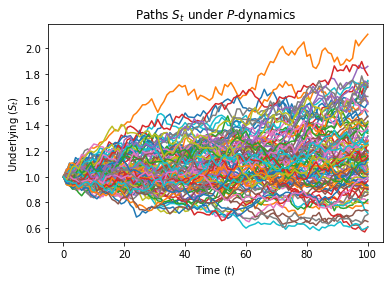

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Subtract, Multiply, Lambda, Add
from keras.models import Model
from keras import initializers
import keras.backend as K

# Input variables
N = 100 # time descritization
S0 = 100
strike = 100
T = 2
a = 0.2
mu = 0.06
R = 100
activator = "tanh"
Ktrain = 20000 # Size of training data
Ktest = 1000 # Size of test data
epochs = 20

## Normalising initial value to of S0 to 1 (1 unit of money = price of S0)
strike = strike/S0
S0 = 1

def sigma(a, x):
    return(a*np.abs(x)**0.7)

# The following function creates paths from the model
def path(S0, mu, a, N, T, R):
    dt = T/N
    dW = np.random.normal(0, 1, (N, R))*np.sqrt(dt)
    S = np.zeros((N+1, R))
    S[0,:] = [S0]*R
    for i in range(N):
        increment = mu*S[i,:]*dt + sigma(a, S[i,:]) * dW[i,:]
        S[i+1,:] = S[i,:] + increment
    return S

# Creating R sample paths from the model
S = path(S0, mu, a, N, T, R)
for i in range(R):
   plt.plot(S[:,i])
plt.title('Paths $S_t$ under $P$-dynamics')
plt.ylabel('Underlying ($S_t$)')
plt.xlabel('Time ($t$)')
plt.show()

In [ ]:
# Start of the network
m = 1 # dimension of price
d = 2 # number of layers in strategy
n = 64  # nodes

### Architecture of the network --- expecting a price path
# Reading initial price of the risky asset. 'price' stands for current price.
price = Input(shape=(m,))
# Recording the initial wealth and price to the input struture 'inputs'
inputs = [price]

# The starting wealth
wealth = Dense(1, activation='linear', trainable=True)(price)

## Creating position size and new weath from current wealth and new asset price
for j in range(N):
    pricenew = Input(shape=(m,))   # Reading new price
    inputs = inputs + [pricenew]   # Writing new price to the inputs record
    priceshift = Subtract()([pricenew, price])  # Price shift
    ## Creating architecture for the traiding strategy
    for i in range(d):
        ## Choose a layer type
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation=activator,trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        # First layer depends on current price (not newprice)
        if i == 0:
            strategy = layer(price)
        else:
            strategy = layer(strategy)
    ## Calculating trading gains and new wealth
    gains = Multiply()([strategy,priceshift])
    wealth = Add()([wealth,gains])  ## current wealth + gains = newwealth
    ## Setting the next price to be the current price for the next iteration
    price = pricenew
## Producing the terminal payoff
payoff = Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price) 
outputs = Subtract()([payoff,wealth]) # payoff minus terminal wealth

## Defining the model: inputs -> outputs
model_hedge = Model(inputs=inputs, outputs=outputs)
model_hedge.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_608 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 00 (Dense)                     (None, 64)           128         ['input_608[0][0]']              
                                                                                                  
 input_609 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 10 (Dense)                     (None, 1)            65          ['00[0][0]']                     
                                                                                            

In [ ]:
# xtrain consists of the price flow of the risky asset 
trainpaths = path(S0, mu, a, N, T, Ktrain)

## Shaping to input architecture
xtrain = []
for i in range(N+1):
    xtrain = xtrain + [trainpaths[i,:]]
# ytrain is filled with zeros
ytrain = np.zeros((Ktrain, 1))

model_hedge.compile(optimizer='adam',loss='mean_squared_error')
model_hedge.fit(x=xtrain,y=ytrain, epochs=20,verbose=True,batch_size=100)

Epoch 1/20
200/200 [==============================] - 13s 18ms/step - loss: 0.6337
Epoch 2/20
200/200 [==============================] - 3s 17ms/step - loss: 0.0210
Epoch 3/20
200/200 [==============================] - 4s 20ms/step - loss: 0.0129
Epoch 4/20
200/200 [==============================] - 4s 19ms/step - loss: 0.0079
Epoch 5/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0047
Epoch 6/20
200/200 [==============================] - 4s 19ms/step - loss: 0.0029
Epoch 7/20
200/200 [==============================] - 4s 19ms/step - loss: 0.0021
Epoch 8/20
200/200 [==============================] - 4s 21ms/step - loss: 0.0016
Epoch 9/20
200/200 [==============================] - 4s 20ms/step - loss: 0.0014
Epoch 10/20
200/200 [==============================] - 5s 24ms/step - loss: 0.0013
Epoch 11/20
200/200 [==============================] - 5s 25ms/step - loss: 0.0012
Epoch 12/20
200/200 [==============================] - 5s 23ms/step - loss: 0.0011
Epoch 13/20


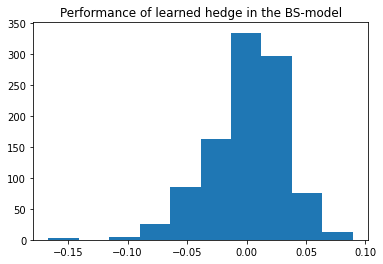

Standard error (learned): 0.031664267
Mean sample error (learned): 0.00049880747


In [ ]:
testpaths = path(S0, mu, a, N, T, Ktest)
## Building test pathes to input architecture
xtest = []
for i in range(N+1):
    xtest = xtest + [testpaths[i,:]]
     
plt.hist(model_hedge.predict(xtest))
plt.title('Performance of learned hedge in the BS-model')
plt.show()
print("Standard error (learned):", np.std(model_hedge.predict(xtest)))
print("Mean sample error (learned):", np.mean(model_hedge.predict(xtest)))

In [ ]:
priceweights = model_hedge.get_weights()
## Search the price!
pos = -1
for i in range(np.shape(priceweights)[0]):
    if np.shape(priceweights[i]) == (1,1):
        pos = i
        lprice = S0*priceweights[i][0][0] + priceweights[i+1][0]
        break
weights = priceweights[0:pos]+priceweights[(pos+2):]

MCprice = np.mean(0.5*(np.abs(trainpaths[N,:] - strike) + trainpaths[N,:] - strike))
print("Learned price:",lprice,". Monte Carlo price:",MCprice)

Learned price: 0.1117282323539257 . Monte Carlo price: 0.1959665562324512


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


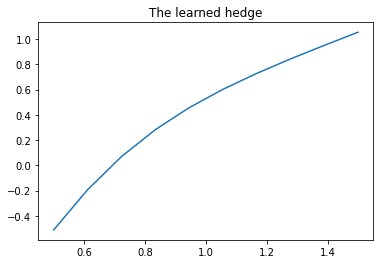

In [ ]:
## Calculating the Delta-hedge 
#This works when the number of layers equals d=2
if activator == "tanh": fun = np.tanh
if activator == "relu":
    def fun(x): return 0.5*(np.abs(x)+x)
def deltastrategy(s,j):
    length=s.shape[0]
    g=np.zeros(length)
    for p in range(length):
        ghelper=fun(s[p]*(weights[j*2*d])+weights[j*2*d+1])
        g[p]=np.sum(np.squeeze(weights[2*(d-1)+j*2*d])*np.squeeze(ghelper))
        g[p]=g[p]+weights[2*d-1+j*2*d]   
    return g

s=np.linspace(0.5, 1.5, 10)
k=50 ## Choses a time point where we compare our 'learned' strategy against the 'true' strategy
learned=deltastrategy(s,k)
plt.plot(s,learned)
plt.title('The learned hedge')
plt.show()

How well does it work under $Q$? </li>

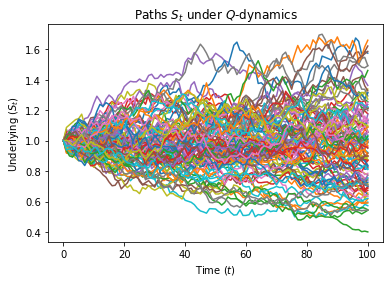

In [ ]:
# The following function creates paths from the model
def pathQ(S0, a, N, T, R):
    dt = T/N
    dW = np.random.normal(0, 1, (N, R))*np.sqrt(dt)
    S = np.zeros((N+1, R))
    S[0,:] = [S0]*R
    for i in range(N):
        sig = sigma(a, S[i,:])
        mu = -sig**2/2  ## Q-dynamics
        increment = mu*S[i,:]*dt + sig*dW[i,:]
        S[i+1,:] = S[i,:] + increment
    return S

# Example simulation of paths
S = pathQ(S0, a, N, T, R)
for i in range(R):
   plt.plot(S[:,i])
plt.title('Paths $S_t$ under $Q$-dynamics')
plt.ylabel('Underlying ($S_t$)')
plt.xlabel('Time ($t$)')
plt.show()

In [ ]:
# xtrain consists of the price flow of the risky asset 
trainpaths = pathQ(S0, a, N, T, Ktrain)
## Shaping to input architecture
xtrain = []
for i in range(N+1):
    xtrain = xtrain + [trainpaths[i,:]]

# ytrain is filled with zeros
ytrain = np.zeros((Ktrain,1))

model_hedge.compile(optimizer='adam',loss='mean_squared_error')
model_hedge.fit(x=xtrain,y=ytrain, epochs=epochs,verbose=True,batch_size=100)

Epoch 1/20
200/200 [==============================] - 14s 18ms/step - loss: 0.0010
Epoch 2/20
200/200 [==============================] - 4s 18ms/step - loss: 0.0010
Epoch 3/20
200/200 [==============================] - 4s 19ms/step - loss: 9.8903e-04
Epoch 4/20
200/200 [==============================] - 4s 18ms/step - loss: 0.0010
Epoch 5/20
200/200 [==============================] - 4s 19ms/step - loss: 9.8450e-04
Epoch 6/20
200/200 [==============================] - 4s 19ms/step - loss: 9.8300e-04
Epoch 7/20
200/200 [==============================] - 4s 17ms/step - loss: 9.3543e-04
Epoch 8/20
200/200 [==============================] - 4s 19ms/step - loss: 9.5198e-04
Epoch 9/20
200/200 [==============================] - 4s 22ms/step - loss: 9.5137e-04
Epoch 10/20
200/200 [==============================] - 4s 19ms/step - loss: 9.3156e-04
Epoch 11/20
200/200 [==============================] - 4s 20ms/step - loss: 9.2119e-04
Epoch 12/20
200/200 [==============================] - 3s 17ms/

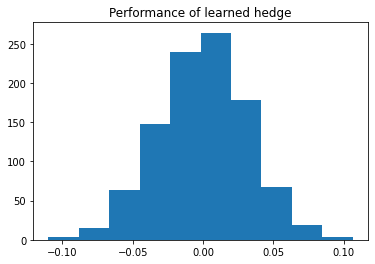

Standard error (learned): 0.03139816
Mean sample error (learned): -0.00014311957


In [ ]:
testpaths = pathQ(S0, a, N, T, Ktest)
    
## Building test pathes to input architecture
xtest = []
for i in range(N+1):
    xtest = xtest + [testpaths[i,:]]
    
plt.hist(model_hedge.predict(xtest))
plt.title('Performance of learned hedge')
plt.show()
print("Standard error (learned):",np.std(model_hedge.predict(xtest)))
print("Mean sample error (learned):",np.mean(model_hedge.predict(xtest)))

In [ ]:
priceweights = model_hedge.get_weights()

## Search the price!
pos = -1
for i in range(np.shape(priceweights)[0]):
    if np.shape(priceweights[i]) == (1,1):
        pos = i
        lprice = S0*priceweights[i][0][0] + priceweights[i+1][0]
        break
weights = priceweights[0:pos]+priceweights[(pos+2):]

MCprice = np.mean(0.5*(np.abs(trainpaths[N,:] - strike) + trainpaths[N,:] - strike))
print("Learned price:",lprice,". Monte Carlo price:",MCprice)

Learned price: 0.11232281476259232 . Monte Carlo price: 0.09012897233812328


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


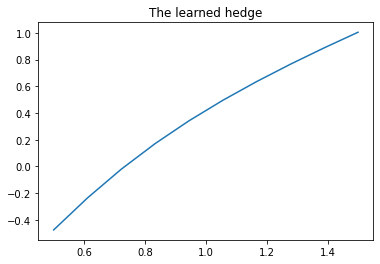

In [ ]:
## Calculating the Delta-hedge 
#This works when the number of layers equals d=2
if activator == "tanh": fun = np.tanh
if activator == "relu":
    def fun(x): return 0.5*(np.abs(x)+x)
def deltastrategy(s,j):
    length=s.shape[0]
    g=np.zeros(length)
    for p in range(length):
        ghelper=fun(s[p]*(weights[j*2*d])+weights[j*2*d+1])
        g[p]=np.sum(np.squeeze(weights[2*(d-1)+j*2*d])*np.squeeze(ghelper))
        g[p]=g[p]+weights[2*d-1+j*2*d]   
    return g

s=np.linspace(0.5, 1.5, 10)
k=50 ## Choses a time point where we compare our 'learned' strategy against the 'true' strategy
learned=deltastrategy(s,k)
plt.plot(s,learned)
plt.title('The learned hedge')
plt.show()

In conclusion, we can see that the models under the $Q$-dynamics better learn the behaviour of the call option. We follow this as the learned and MC prices are closer and the standard error of the prediction and its MSE under the $Q$-dynamics are lower as well.

### **Exercise 2 (Constant volvol SABR-model)**

Write a Deep-calibration algorithm using the $Q$-dynamics of the following model:
 $$ dS_t = \sigma(S_t) dW_t,\quad S_0 = 100, $$
 where $\sigma(x) = a |x|^{0.7}$ and $a \in [0.1, 0.5]$ is the unknown parameter. Choose $3$ options and possibly also include the underlying as instruments for calibration.</p>

Do you get your parameter $a$ back well?

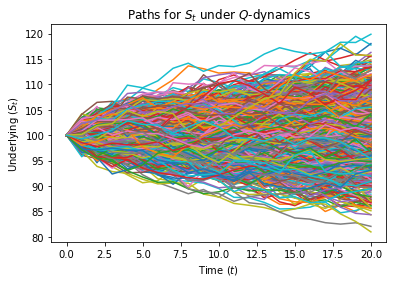

In [ ]:
import random
N = 20 # time disrectization
S0 = 100 # initial value of the asset in multiples of np.exp(5)
T = 2.0 # maturity
activator = "tanh"
R = 1000 # Number of path used in the MC simulation
Ktrain = 20000 # Size of training data
Ktest = 50 # Size of test data
epochs = 10

def pathC(S0, a, N, T, R):
    dt = T/N
    dW = np.random.normal(0, 1, (N, R))*np.sqrt(dt)
    S = np.zeros((N+1, R))
    S[0,:] = [S0]*R
    for i in range(N):
        increment = sigma(a, S[i,:])*dW[i,:]
        S[i+1,:] = S[i,:] + increment
    return S

# Example simulation of paths with a = 0.2
S = pathC(S0, a, N, T, R)
for i in range(R):
   plt.plot(S[:,i])
plt.title('Paths for $S_t$ under $Q$-dynamics')
plt.ylabel('Underlying ($S_t$)')
plt.xlabel('Time ($t$)')
plt.show()

In [ ]:
## payoff(s) function
n_opt = 3  # three options
def f(S):
    y = []
    for K in (80,100,150):
        payoff = (np.abs(S-K)+(S-K))/2
        y = y + [payoff]
    return y

# Creating Ktrain sample paths from the model
import random
a = random.uniform(0.1, 0.5)
S = np.zeros((Ktrain, R))
F = np.zeros((Ktrain, n_opt))
for i in range(Ktrain):
    S[i,:] = pathC(S0, a, N, T, R)[N,:]  ## We store only the final values
    L = f(S[i,:])
    Lmean = np.zeros( (n_opt,) )
    for j in range(n_opt):
        Lmean[j] = np.mean(L[j])
    F[i,:] = Lmean

In [ ]:
## Building model
depth = 8
nodes = 64

out = Input(shape=(n_opt,))
inputs = [out]
for i in range(depth):
    out = Dense(nodes, activation=activator, trainable=True)(out)
outputs = Dense(1, activation=activator, trainable=True)(out)

model_par = Model(inputs=inputs, outputs=outputs)
model_par.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_710 (InputLayer)      [(None, 3)]               0         
                                                                 
 dense_14 (Dense)            (None, 64)                256       
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 64)                4160

In [ ]:
A = np.ones((Ktrain, )) * a
model_par.compile(optimizer='adam',loss='mean_squared_error')
model_par.fit(x=F,y=A, epochs=epochs,verbose=True,batch_size=100)

Epoch 1/10
200/200 [==============================] - 2s 3ms/step - loss: 0.0023
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 6.8203e-09
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 3.7262e-09
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 2.5619e-09
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 2.0019e-09
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 1.8701e-09
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 1.8495e-09
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 1.8579e-09
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 1.6707e-09
Epoch 10/10
200/200 [==============================] - 1s 3ms/step - loss: 2.5754e-09


Do you get your parameter $a$ back well?

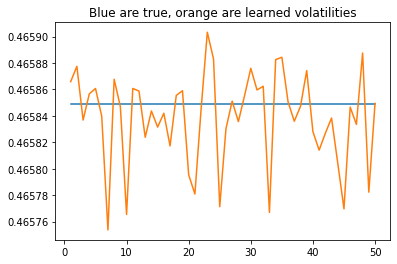

In [ ]:
# Creating Ktest sample paths from the model
A = np.ones((Ktest,))*a
S = np.zeros((Ktest, R))
F = np.zeros((Ktest, n_opt))
for i in range(Ktest):
    S[i,:] = pathC(S0, a, N, T, R)[N,:]  ## We store only the final values
    L = f(S[i,:])
    Lmean = np.zeros((n_opt,))
    for j in range(n_opt):
        Lmean[j] = np.mean(L[j])
    F[i,:] = Lmean

A_pred = np.squeeze(model_par.predict(F))
xaxis = np.linspace(1, Ktest, Ktest)

plt.plot(xaxis, A, '-', xaxis, A_pred, '-')
plt.title("Blue are true, orange are learned volatilities")
plt.show()

In [ ]:
A_diff = A_pred - A
relmean = np.mean(A_diff/ A)
relvar = np.sqrt(np.var(A_diff/ A))
print("Error is on average",round(relmean*100,ndigits=5),"% from the truth with a standard error of:",round(relvar*100,ndigits=5),"%.")

Error is on average -0.0022 % from the truth with a standard error of: 0.0075 %.
